In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil
import pandas as pd
import seaborn as sns

np.random.seed(1)

# 1. Naive Bayes Classifier

### Helper Methods

#### I. Group the dataset into classes

In [ ]:
def split_classes(samples, labels):
  # a dictionary having labels as keys, and a list of samples as values for each label
  label_dict = {0: [], 1: []}

  # assign samples to their buckets
  for indx, sample in enumerate(samples):
    label = labels[indx]
    label_dict[label].append(sample)

  # convert lists into numpy arrays
  label_dict[0] = np.array(label_dict[0])
  label_dict[1] = np.array(label_dict[1])

  return label_dict

#### II. Frequentist Statistics Parameters


In [ ]:
def freq_stat_param(x, y):

  cond_red = np.zeros(16)
  cond_green = np.zeros(16)
  cond_blue = np.zeros(16)

  cond_prob = np.zeros((2, 3, 16, 1), dtype=np.float64)
  classes_prob = np.zeros((2), dtype=np.float64)

  for (xi, yi) in zip(x,y):
    red = int(xi[0] // 16)
    green = int(xi[1] // 16)
    blue = int(xi[2] // 16)

    cond_prob[yi, 0, red] += 1
    cond_prob[yi, 1, green] += 1
    cond_prob[yi, 2, blue] += 1

    classes_prob[yi] += 1

  cond_prob[0] /= classes_prob[0]
  cond_prob[1] /= classes_prob[1]
 
  classes_prob /= y.shape[0]

  return cond_prob, classes_prob

#### III. Probability of Input Given Class

In [ ]:
def p_x_class(cond_probs, sample, label):
  red = int(sample[0] // 16)
  green = int(sample[1] // 16)
  blue = int(sample[2] // 16)

  return cond_probs[label][0][red] * cond_probs[label][1][green] * cond_probs[label][2][blue]

#### IV. Probability of Classes

In [ ]:
def get_class_given_x(samples, cond_probs, classes_probs):

  num_of_samples = samples.shape[0]

  probs = np.zeros((num_of_samples, 2), dtype=np.float64)

  for i in range(num_of_samples):
    sample = samples[i]
    probs[i, 0] = p_x_class(cond_probs, sample, 0) * classes_probs[0]
    probs[i, 1] = p_x_class(cond_probs, sample, 1) * classes_probs[1]

  return probs

#### V. Train Test Split

In [ ]:
def train_test_split(img, bin):
  indices = np.random.permutation(img.shape[0])

  training_pixel_num = ceil(img.shape[0] * 0.8)

  training_idx = indices[:training_pixel_num]
  test_idx = indices[training_pixel_num:]

  training_x, test_x = img[training_idx], img[test_idx]
  training_y, test_y = bin[training_idx], bin[test_idx]

  return training_x, training_y, training_idx, test_x, test_y, test_idx

### Naive Bayes Classifier Class


In [ ]:
class BM:
  def BayesModel(dta, gt):
    cond_probs, classes_probs = freq_stat_param(dta, gt)
    return cond_probs, classes_probs

  def fit(self, dta, gt):
    self.cond_probs, self.classes_probs = BM.BayesModel(dta, gt)
  
  def BayesPredict(self, td):
    # get the probability of the test set belonging to each class
    probs = get_class_given_x(td, self.cond_probs, self.classes_probs)
    # get the predictions 
    y_pred = np.argmax(probs, axis=1)

    return y_pred

  def ConfMtrx(gt, lbl):
    confusion = np.zeros((2, 2)) # matrix size for 2 classes

    # populate the matrix
    for i in range(len(gt)):
      confusion[lbl[i], gt[i]]+=1

    confusion_df = pd.DataFrame(confusion, [0, 1], [0, 1])
    confusion_df.index.name = 'Actual'
    confusion_df.columns.name = 'Predicted'
    sns.set(font_scale=1.5)
    sns.heatmap(confusion_df,cmap="vlag", annot=True, annot_kws={"size": 20}, fmt='g')
    plt.show()

    return confusion




---



# Applying NB

## I. Loading the Image and Applying Quantization and Thresholding

In [ ]:
def quantize(img, IQ):
  img_quantized = np.zeros(img.shape)

  rows = img.shape[0]
  cols = img.shape[1]

  for i in range(rows):
    for j in range(cols):
      img_quantized[i,j] = IQ * (img[i,j] // IQ)

  return img_quantized

In [ ]:
def otsu(img):
  # Set total number of bins in the histogram
  bins_num = 256
  # Get the image histogram
  hist, bin_edges = np.histogram(img, bins=bins_num)
  # Get normalized histogram if it is required
  hist = np.divide(hist.ravel(), hist.max())
  # Calculate centers of bins
  bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
  # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
  weight1 = np.cumsum(hist)
  weight2 = np.cumsum(hist[::-1])[::-1]
  # Get the class means mu0(t)
  mean1 = np.cumsum(hist * bin_mids) / weight1
  # Get the class means mu1(t)
  mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
  inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
  # Maximize the inter_class_variance function val
  index_of_max_val = np.argmax(inter_class_variance)
  threshold = bin_mids[:-1][index_of_max_val]
  return threshold

In [ ]:
img_c = np.asarray(Image.open('Data/71046c.jpeg'))

img_gs = np.asarray(Image.open('Data/71046.jpeg'))
threshold = otsu(img_gs)
img_bin = (img_gs > threshold)

IQ = 16
img_c_quantized = quantize(img_c, IQ).reshape(-1, 3)

train_x, train_y, train_idx, test_x, test_y, test_idx = train_test_split(img_c_quantized, np.reshape(img_bin.astype(np.int8), -1))

# II. Training and Testing the NB Model

In [ ]:
bm = BM()

bm.fit(train_x, train_y)

y_pred = bm.BayesPredict(test_x)

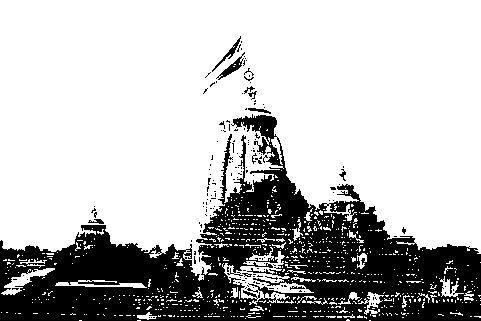

In [ ]:
ground_truth = Image.fromarray((img_bin * 255).astype('uint8'), 'L')
ground_truth

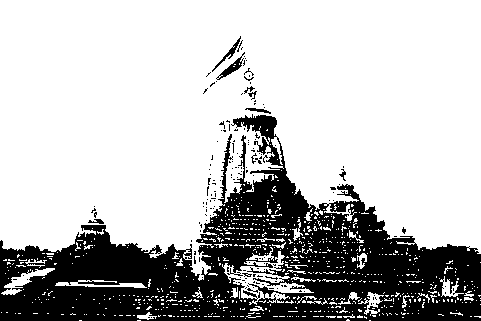

In [ ]:
new_image = np.zeros(img_c_quantized.shape[0])

new_image[train_idx] = train_y
new_image[test_idx] = y_pred
new_image = (new_image * 255).astype('uint8')

img_pred = Image.fromarray(new_image.reshape(img_bin.shape), 'L')
img_pred

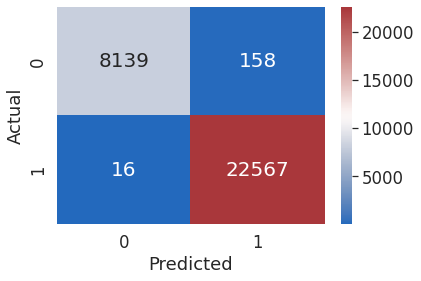

In [ ]:
c = BM.ConfMtrx(test_y, y_pred)